In [1]:
import numpy as np
import sys
np.set_printoptions(precision=5, linewidth=200, suppress=True)
import psi4
from helper_PFCI import PFHamiltonianGenerator
from helper_PFCI import Determinant
from helper_cqed_rhf import cqed_rhf
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)

For both lambda = 0.01 and 0.08 do:
- Do Minimal basis pCQED (Nel = 2, Np = 2)
- Do large basis pCQED (Nel = 50, Np = 10)
- Do minimal basis QED-FCI (Np = 1)
- Do large basis QED-FCI (Np = 6)

In [2]:
# options for mgf
mol_str = """
Li
H 1 1.5
symmetry c1
"""

options_dict = {
    "basis": "sto-3g", ### STO-3G is "Slater-type orbital - 3 Gaussian functions
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    "save_jk" : True
}


psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)


In [3]:
mol_str = """
Li
H 1 1.5
symmetry c1
"""

options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

pcqed_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'number_of_photons' : 0
}

scqed_dict_np1 = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'number_of_photons' : 1
}

scqed_dict_np6 = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'number_of_photons' : 6
}


mol = psi4.geometry(mol_str)
psi4.set_options(options_dict)

pcqed_res = PFHamiltonianGenerator(
    mol_str,
    options_dict,
    pcqed_dict
)

scqed_res_np1 = PFHamiltonianGenerator(
    mol_str,
    options_dict,
    scqed_dict_np1
)

scqed_res_np6 = PFHamiltonianGenerator(
    mol_str,
    options_dict,
    scqed_dict_np6
)

print(np.shape(pcqed_res.H_PF))
print(np.shape(scqed_res_np1.H_PF))
print(np.shape(scqed_res_np6.H_PF))


Start SCF iterations:

Canonical RHF One-electron energy = -12.5626302721254888
CQED-RHF One-electron energy      = -12.5626302721254888
Nuclear repulsion energy          = 1.0583544213400000
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8633576215383245   dE = -7.86336E+00   dRMS = 3.54851E-13
SCF Iteration   2: Energy = -7.8633576215383458   dE = -2.13163E-14   dRMS = 8.00882E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86335762 hartree
Psi4  SCF energy: -7.86335762 hartree
 Completed QED-RHF in 0.23401594161987305 seconds
 Completed 1HSO Build in 5.1975250244140625e-05 seconds
 Completed ERI Build in 0.001146078109741211 seconds 
 Completed 2D build in 0.0001590251922607422 seconds
 Completed 1G build in 1.3828277587890625e-05 seconds
 Completed the Dipole Matrix Build in 3.910064697265625e-05 seconds
 Completed determinant list in 0.0004470348358154297 seconds 
 Completed constant offset matrix in 0.000136852264404

In [4]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""

mol_str = """
Li
H 1 1.5
symmetry c1
"""

N_R = 40       
N_el = 50
r_array = np.linspace(1.4, 2.0, N_R)

# for pcqed results
E_array = np.zeros((N_R, N_el))
Mu_array = np.zeros((N_R, N_el, N_el, 3))

# scqed results
sc_np1_E_array = np.zeros((N_R, 10))
sc_np6_E_array = np.zeros((N_R, 10))

psi4.set_options(options_dict)

r_idx = 0
for r in r_array:
    mol_str = mol_tmpl.replace("**R**", str(r))
    print(mol_str)
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy = psi4.energy('fci',ref_wfn=wfn)
    
    # pcqed results
    pcqed_res = PFHamiltonianGenerator(mol_str, options_dict, pcqed_dict)
    assert np.isclose(fci_energy, pcqed_res.CIeigs[0], 1e-7)
    
    # sort out states with dipole-allowed transition from ground state
    singlet_states = pcqed_res.sort_dipole_allowed_states( N_el)
    
    # store values
    E_array[r_idx, :] = pcqed_res.CIeigs[singlet_states]
    Mu_array[r_idx, :, :, :] = pcqed_res.compute_dipole_moments(singlet_states)
    
    # scqed results
    cqed_res_np1 = PFHamiltonianGenerator(mol_str, options_dict, scqed_dict_np1)
    sc_np1_E_array[r_idx, :] = cqed_res_np1.CIeigs[:10]
    
    cqed_res_np6 = PFHamiltonianGenerator(mol_str, options_dict, scqed_dict_np6)
    sc_np6_E_array[r_idx, :] = cqed_res_np6.CIeigs[:10]
    

    
    r_idx += 1




Li
H 1 1.4
symmetry c1


Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236296037
CQED-RHF One-electron energy      = -12.6946346236296037
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8605386610570473   dE = -7.86054E+00   dRMS = 1.78805E-13
SCF Iteration   2: Energy = -7.8605386610570385   dE =  8.88178E-15   dRMS = 3.97663E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86053866 hartree
Psi4  SCF energy: -7.86053866 hartree
 Completed QED-RHF in 0.08752322196960449 seconds
 Completed 1HSO Build in 6.103515625e-05 seconds
 Completed ERI Build in 0.0012021064758300781 seconds 
 Completed 2D build in 7.414817810058594e-05 seconds
 Completed 1G build in 1.3828277587890625e-05 seconds
 Completed the Dipole Matrix Build in 3.910064697265625e-05 seconds
 Completed determinant list in 0.00043702125549316406 seconds 
 Completed constant offset matrix 

 Completed Hamiltonian build in 0.6890439987182617 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.6529469247599842
CQED-RHF One-electron energy      = -12.6390157266810590
Nuclear repulsion energy          = 1.1095651191467744
Dipole energy                     = 0.0131545673361482
SCF Iteration   1: Energy = -7.8580175927625255   dE = -7.85802E+00   dRMS = 3.19538E-04
SCF Iteration   2: Energy = -7.8580228586630856   dE = -5.26590E-06   dRMS = 4.47270E-05
SCF Iteration   3: Energy = -7.8580231006460739   dE = -2.41983E-07   dRMS = 1.56708E-05
SCF Iteration   4: Energy = -7.8580231414024233   dE = -4.07563E-08   dRMS = 1.74312E-07
SCF Iteration   5: Energy = -7.8580231414031640   dE = -7.40741E-13   dRMS = 1.64605E-09
SCF Iteration   6: Energy = -7.8580231414031605   dE =  3.55271E-15   dRMS = 1.14381E-10
SCF Iteration   7: Energy = -7.8580231414031623   dE = -1.77636E-15   dRMS = 9.26489E-15
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6795430183410645 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.6122245277260934
CQED-RHF One-electron energy      = -12.5979943639630996
Nuclear repulsion energy          = 1.0862058534805263
Dipole energy                     = 0.0134048753304416
SCF Iteration   1: Energy = -7.8588619255481706   dE = -7.85886E+00   dRMS = 3.19679E-04
SCF Iteration   2: Energy = -7.8588675611287861   dE = -5.63558E-06   dRMS = 5.06220E-05
SCF Iteration   3: Energy = -7.8588679001714024   dE = -3.39043E-07   dRMS = 1.86046E-05
SCF Iteration   4: Energy = -7.8588679574145583   dE = -5.72432E-08   dRMS = 2.17867E-07
SCF Iteration   5: Energy = -7.8588679574162867   dE = -1.72840E-12   dRMS = 3.33321E-09
SCF Iteration   6: Energy = -7.8588679574162885   dE = -1.77636E-15   dRMS = 1.83125E-10
SCF Iteration   7: Energy = -7.8588679574162867   dE =  1.77636E-15   dRMS = 3.75845E-14
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.678419828414917 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.5724354198755996
CQED-RHF One-electron energy      = -12.5578986158662573
Nuclear repulsion energy          = 1.0638098565015472
Dipole energy                     = 0.0136595648954619
SCF Iteration   1: Energy = -7.8592493149894276   dE = -7.85925E+00   dRMS = 3.20981E-04
SCF Iteration   2: Energy = -7.8592554124259548   dE = -6.09744E-06   dRMS = 5.70631E-05
SCF Iteration   3: Energy = -7.8592558706617934   dE = -4.58236E-07   dRMS = 2.13916E-05
SCF Iteration   4: Energy = -7.8592559461174138   dE = -7.54556E-08   dRMS = 2.70845E-07
SCF Iteration   5: Energy = -7.8592559461207570   dE = -3.34310E-12   dRMS = 4.72292E-09
SCF Iteration   6: Energy = -7.8592559461207587   dE = -1.77636E-15   dRMS = 2.33058E-10
SCF Iteration   7: Energy = -7.8592559461207552   dE =  3.55271E-15   dRMS = 8.45369E-14
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.859

 Completed Hamiltonian build in 0.6715891361236572 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.5335482069792423
CQED-RHF One-electron energy      = -12.5186969617514379
Nuclear repulsion energy          = 1.0423187482893939
Dipole energy                     = 0.0139187385918502
SCF Iteration   1: Energy = -7.8592183357136891   dE = -7.85922E+00   dRMS = 3.23466E-04
SCF Iteration   2: Energy = -7.8592249923020310   dE = -6.65659E-06   dRMS = 6.39293E-05
SCF Iteration   3: Energy = -7.8592255935674116   dE = -6.01265E-07   dRMS = 2.40336E-05
SCF Iteration   4: Energy = -7.8592256885966032   dE = -9.50292E-08   dRMS = 3.28105E-07
SCF Iteration   5: Energy = -7.8592256886021596   dE = -5.55644E-12   dRMS = 5.91090E-09
SCF Iteration   6: Energy = -7.8592256886021596   dE =  0.00000E+00   dRMS = 2.82910E-10
SCF Iteration   7: Energy = -7.8592256886021614   dE = -1.77636E-15   dRMS = 1.53874E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6754150390625 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.4955324074488949
CQED-RHF One-electron energy      = -12.4803587955476250
Nuclear repulsion energy          = 1.0216787730757424
Dipole energy                     = 0.0141824804548821
SCF Iteration   1: Energy = -7.8588042307954469   dE = -7.85880E+00   dRMS = 3.27148E-04
SCF Iteration   2: Energy = -7.8588115496668332   dE = -7.31887E-06   dRMS = 7.11448E-05
SCF Iteration   3: Energy = -7.8588123196581892   dE = -7.69991E-07   dRMS = 2.65364E-05
SCF Iteration   4: Energy = -7.8588124353342499   dE = -1.15676E-07   dRMS = 3.87710E-07
SCF Iteration   5: Energy = -7.8588124353426254   dE = -8.37552E-12   dRMS = 6.99887E-09
SCF Iteration   6: Energy = -7.8588124353426325   dE = -7.10543E-15   dRMS = 3.34390E-10
SCF Iteration   7: Energy = -7.8588124353426272   dE =  5.32907E-15   dRMS = 2.49359E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85881

 Completed Hamiltonian build in 0.6747138500213623 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.4583586544286504
CQED-RHF One-electron energy      = -12.4428546303778305
Nuclear repulsion energy          = 1.0018403502975730
Dipole energy                     = 0.0144508548091222
SCF Iteration   1: Energy = -7.8580392464372748   dE = -7.85804E+00   dRMS = 3.32031E-04
SCF Iteration   2: Energy = -7.8580473372505013   dE = -8.09081E-06   dRMS = 7.86626E-05
SCF Iteration   3: Energy = -7.8580483036601292   dE = -9.66410E-07   dRMS = 2.89096E-05
SCF Iteration   4: Energy = -7.8580484408516105   dE = -1.37191E-07   dRMS = 4.49116E-07
SCF Iteration   5: Energy = -7.8580484408634641   dE = -1.18536E-11   dRMS = 8.04344E-09
SCF Iteration   6: Energy = -7.8580484408634623   dE =  1.77636E-15   dRMS = 3.87809E-10
SCF Iteration   7: Energy = -7.8580484408634641   dE = -1.77636E-15   dRMS = 3.76010E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6746702194213867 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.4219988259780791
CQED-RHF One-electron energy      = -12.4061562306511632
Nuclear repulsion energy          = 0.9827576769585715
Dipole energy                     = 0.0147239056466463
SCF Iteration   1: Energy = -7.8569529244612388   dE = -7.85695E+00   dRMS = 3.38108E-04
SCF Iteration   2: Energy = -7.8569619040745584   dE = -8.97961E-06   dRMS = 8.64539E-05
SCF Iteration   3: Energy = -7.8569630967131525   dE = -1.19264E-06   dRMS = 3.11652E-05
SCF Iteration   4: Energy = -7.8569632561675755   dE = -1.59454E-07   dRMS = 5.12391E-07
SCF Iteration   5: Energy = -7.8569632561835911   dE = -1.60156E-11   dRMS = 9.07766E-09
SCF Iteration   6: Energy = -7.8569632561835929   dE = -1.77636E-15   dRMS = 4.43503E-10
SCF Iteration   7: Energy = -7.8569632561835894   dE =  3.55271E-15   dRMS = 5.40683E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6734390258789062 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.3864261193403582
CQED-RHF One-electron energy      = -12.3702366877282994
Nuclear repulsion energy          = 0.9643883745855140
Dipole energy                     = 0.0150016564354049
SCF Iteration   1: Energy = -7.8555723591366640   dE = -7.85557E+00   dRMS = 3.45368E-04
SCF Iteration   2: Energy = -7.8555823522624824   dE = -9.99313E-06   dRMS = 9.45015E-05
SCF Iteration   3: Energy = -7.8555838031746443   dE = -1.45091E-06   dRMS = 3.33176E-05
SCF Iteration   4: Energy = -7.8555839855987344   dE = -1.82424E-07   dRMS = 5.77880E-07
SCF Iteration   5: Energy = -7.8555839856197256   dE = -2.09912E-11   dRMS = 1.01237E-08
SCF Iteration   6: Energy = -7.8555839856197238   dE =  1.77636E-15   dRMS = 5.02188E-10
SCF Iteration   7: Energy = -7.8555839856197274   dE = -3.55271E-15   dRMS = 7.54155E-13
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.678617000579834 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.3516150820279247
CQED-RHF One-electron energy      = -12.3350704519887753
Nuclear repulsion energy          = 0.9466931750518348
Dipole energy                     = 0.0152841102422010
SCF Iteration   1: Energy = -7.8539224238035965   dE = -7.85392E+00   dRMS = 3.53789E-04
SCF Iteration   2: Energy = -7.8539335636499077   dE = -1.11398E-05   dRMS = 1.02796E-04
SCF Iteration   3: Energy = -7.8539353072272542   dE = -1.74358E-06   dRMS = 3.53826E-05
SCF Iteration   4: Energy = -7.8539355133613880   dE = -2.06134E-07   dRMS = 6.46062E-07
SCF Iteration   5: Energy = -7.8539355133882713   dE = -2.68834E-11   dRMS = 1.11986E-08
SCF Iteration   6: Energy = -7.8539355133882731   dE = -1.77636E-15   dRMS = 5.65136E-10
SCF Iteration   7: Energy = -7.8539355133882767   dE = -3.55271E-15   dRMS = 1.03275E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.853

 Completed Hamiltonian build in 0.6742501258850098 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.3175416098981749
CQED-RHF One-electron energy      = -12.3006333315540477
Nuclear repulsion energy          = 0.9296356403662163
Dipole energy                     = 0.0155712500667098
SCF Iteration   1: Energy = -7.8520259718273593   dE = -7.85203E+00   dRMS = 3.63343E-04
SCF Iteration   2: Energy = -7.8520384007308532   dE = -1.24289E-05   dRMS = 1.11331E-04
SCF Iteration   3: Energy = -7.8520404738260492   dE = -2.07310E-06   dRMS = 3.73770E-05
SCF Iteration   4: Energy = -7.8520407045118183   dE = -2.30686E-07   dRMS = 7.17490E-07
SCF Iteration   5: Energy = -7.8520407045456899   dE = -3.38716E-11   dRMS = 1.23176E-08
SCF Iteration   6: Energy = -7.8520407045456935   dE = -3.55271E-15   dRMS = 6.34327E-10
SCF Iteration   7: Energy = -7.8520407045456899   dE =  3.55271E-15   dRMS = 1.40173E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85

 Completed Hamiltonian build in 0.6946859359741211 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.2841829204479769
CQED-RHF One-electron energy      = -12.2669024659620121
Nuclear repulsion energy          = 0.9131819122181416
Dipole energy                     = 0.0158630393013261
SCF Iteration   1: Energy = -7.8499040156396012   dE = -7.84990E+00   dRMS = 3.74000E-04
SCF Iteration   2: Energy = -7.8499178856966010   dE = -1.38701E-05   dRMS = 1.20107E-04
SCF Iteration   3: Energy = -7.8499203277405742   dE = -2.44204E-06   dRMS = 3.93179E-05
SCF Iteration   4: Energy = -7.8499205839815955   dE = -2.56241E-07   dRMS = 7.92758E-07
SCF Iteration   5: Energy = -7.8499205840237485   dE = -4.21529E-11   dRMS = 1.34954E-08
SCF Iteration   6: Energy = -7.8499205840237520   dE = -3.55271E-15   dRMS = 7.12615E-10
SCF Iteration   7: Energy = -7.8499205840237467   dE =  5.32907E-15   dRMS = 1.89783E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.84

 Completed Hamiltonian build in 0.692112922668457 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.2515175079731442
CQED-RHF One-electron energy      = -12.2338562814954717
Nuclear repulsion energy          = 0.8973004876578262
Dipole energy                     = 0.0161594222444633
SCF Iteration   1: Energy = -7.8475758869738108   dE = -7.84758E+00   dRMS = 3.85724E-04
SCF Iteration   2: Energy = -7.8475913606766241   dE = -1.54737E-05   dRMS = 1.29123E-04
SCF Iteration   3: Energy = -7.8475942138006491   dE = -2.85312E-06   dRMS = 4.12227E-05
SCF Iteration   4: Energy = -7.8475944968176048   dE = -2.83017E-07   dRMS = 8.72485E-07
SCF Iteration   5: Energy = -7.8475944968696147   dE = -5.20100E-11   dRMS = 1.47481E-08
SCF Iteration   6: Energy = -7.8475944968696236   dE = -8.88178E-15   dRMS = 8.03934E-10
SCF Iteration   7: Energy = -7.8475944968696183   dE =  5.32907E-15   dRMS = 2.57547E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.847

 Completed Hamiltonian build in 0.6845769882202148 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.2195250859903002
CQED-RHF One-electron energy      = -12.2014744336082792
Nuclear repulsion energy          = 0.8819620177833333
Dipole energy                     = 0.0164603246102921
SCF Iteration   1: Energy = -7.8450593808760019   dE = -7.84506E+00   dRMS = 3.98480E-04
SCF Iteration   2: Energy = -7.8450766317628915   dE = -1.72509E-05   dRMS = 1.38382E-04
SCF Iteration   3: Energy = -7.8450799409269081   dE = -3.30916E-06   dRMS = 4.31085E-05
SCF Iteration   4: Energy = -7.8450802522083016   dE = -3.11281E-07   dRMS = 9.57310E-07
SCF Iteration   5: Energy = -7.8450802522720604   dE = -6.37588E-11   dRMS = 1.60939E-08
SCF Iteration   6: Energy = -7.8450802522720657   dE = -5.32907E-15   dRMS = 9.13536E-10
SCF Iteration   7: Energy = -7.8450802522720711   dE = -5.32907E-15   dRMS = 3.51283E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.84

 Completed Hamiltonian build in 0.6837880611419678 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.1881865212876299
CQED-RHF One-electron energy      = -12.1697377408535683
Nuclear repulsion energy          = 0.8671391267281512
Dipole energy                     = 0.0167656539922005
SCF Iteration   1: Energy = -7.8423708856415928   dE = -7.84237E+00   dRMS = 4.12230E-04
SCF Iteration   2: Energy = -7.8423900989702240   dE = -1.92133E-05   dRMS = 1.47888E-04
SCF Iteration   3: Energy = -7.8423939120985793   dE = -3.81313E-06   dRMS = 4.49922E-05
SCF Iteration   4: Energy = -7.8423942534488322   dE = -3.41350E-07   dRMS = 1.04789E-06
SCF Iteration   5: Energy = -7.8423942535266349   dE = -7.78027E-11   dRMS = 1.75550E-08
SCF Iteration   6: Energy = -7.8423942535266420   dE = -7.10543E-15   dRMS = 1.04827E-09
SCF Iteration   7: Energy = -7.8423942535266384   dE =  3.55271E-15   dRMS = 4.82057E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.84

 Completed Hamiltonian build in 0.6935570240020752 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.1574837631191564
CQED-RHF One-electron energy      = -12.1386281138593954
Nuclear repulsion energy          = 0.8528062486004133
Dipole energy                     = 0.0170753002510761
SCF Iteration   1: Energy = -7.8395255004841422   dE = -7.83953E+00   dRMS = 4.26939E-04
SCF Iteration   2: Energy = -7.8395468739382883   dE = -2.13735E-05   dRMS = 1.57644E-04
SCF Iteration   3: Energy = -7.8395512420641564   dE = -4.36813E-06   dRMS = 4.68904E-05
SCF Iteration   4: Energy = -7.8395516156509961   dE = -3.73587E-07   dRMS = 1.14489E-06
SCF Iteration   5: Energy = -7.8395516157456138   dE = -9.46176E-11   dRMS = 1.91593E-08
SCF Iteration   6: Energy = -7.8395516157456209   dE = -7.10543E-15   dRMS = 1.21685E-09
SCF Iteration   7: Energy = -7.8395516157456262   dE = -5.32907E-15   dRMS = 6.65527E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.83

 Completed Hamiltonian build in 0.6751360893249512 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.1273997703384584
CQED-RHF One-electron energy      = -12.1081284821721056
Nuclear repulsion energy          = 0.8389394803304878
Dipole energy                     = 0.0173891358124480
SCF Iteration   1: Energy = -7.8365371424598997   dE = -7.83654E+00   dRMS = 4.42571E-04
SCF Iteration   2: Energy = -7.8365608868999654   dE = -2.37444E-05   dRMS = 1.67656E-04
SCF Iteration   3: Energy = -7.8365658643195708   dE = -4.97742E-06   dRMS = 4.88191E-05
SCF Iteration   4: Energy = -7.8365662727224343   dE = -4.08403E-07   dRMS = 1.24900E-06
SCF Iteration   5: Energy = -7.8365662728372332   dE = -1.14799E-10   dRMS = 2.09426E-08
SCF Iteration   6: Energy = -7.8365662728372367   dE = -3.55271E-15   dRMS = 1.43023E-09
SCF Iteration   7: Energy = -7.8365662728372385   dE = -1.77636E-15   dRMS = 9.23472E-12
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.83

 Completed Hamiltonian build in 0.6820669174194336 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.0979184386604040
CQED-RHF One-electron energy      = -12.0782227211751216
Nuclear repulsion energy          = 0.8255164486452000
Dipole energy                     = 0.0177070158683188
SCF Iteration   1: Energy = -7.8334186439429470   dE = -7.83342E+00   dRMS = 4.59097E-04
SCF Iteration   2: Energy = -7.8334449842104519   dE = -2.63403E-05   dRMS = 1.77931E-04
SCF Iteration   3: Energy = -7.8334506286481478   dE = -5.64444E-06   dRMS = 5.07941E-05
SCF Iteration   4: Energy = -7.8334510749094441   dE = -4.46261E-07   dRMS = 1.36091E-06
SCF Iteration   5: Energy = -7.8334510750484760   dE = -1.39032E-10   dRMS = 2.29509E-08
SCF Iteration   6: Energy = -7.8334510750484867   dE = -1.06581E-14   dRMS = 1.70189E-09
SCF Iteration   7: Energy = -7.8334510750484867   dE =  0.00000E+00   dRMS = 1.28613E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.83

 Completed Hamiltonian build in 0.6799831390380859 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.0690245297220979
CQED-RHF One-electron energy      = -12.0488955807689422
Nuclear repulsion energy          = 0.8125161896114172
Dipole energy                     = 0.0180287784899312
SCF Iteration   1: Energy = -7.8301818417559215   dE = -7.83018E+00   dRMS = 4.76486E-04
SCF Iteration   2: Energy = -7.8302110175412949   dE = -2.91758E-05   dRMS = 1.88477E-04
SCF Iteration   3: Energy = -7.8302173903264229   dE = -6.37279E-06   dRMS = 5.28305E-05
SCF Iteration   4: Energy = -7.8302178780072449   dE = -4.87681E-07   dRMS = 1.48133E-06
SCF Iteration   5: Energy = -7.8302178781754161   dE = -1.68171E-10   dRMS = 2.52426E-08
SCF Iteration   6: Energy = -7.8302178781754375   dE = -2.13163E-14   dRMS = 2.04844E-09
SCF Iteration   7: Energy = -7.8302178781754339   dE =  3.55271E-15   dRMS = 1.79515E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.83

 Completed Hamiltonian build in 0.69126296043396 seconds

Start SCF iterations:

Canonical RHF One-electron energy = -12.0407036031743448
CQED-RHF One-electron energy      = -12.0201326170543688
Nuclear repulsion energy          = 0.7999190393848838
Dipole energy                     = 0.0183542446665732
SCF Iteration   1: Energy = -7.8268376589023472   dE = -7.82684E+00   dRMS = 4.94714E-04
SCF Iteration   2: Energy = -7.8268699256846190   dE = -3.22668E-05   dRMS = 1.99302E-04
SCF Iteration   3: Energy = -7.8268770919406148   dE = -7.16626E-06   dRMS = 5.49436E-05
SCF Iteration   4: Energy = -7.8268776251824494   dE = -5.33242E-07   dRMS = 1.61100E-06
SCF Iteration   5: Energy = -7.8268776253857055   dE = -2.03256E-10   dRMS = 2.78909E-08
SCF Iteration   6: Energy = -7.8268776253857286   dE = -2.30926E-14   dRMS = 2.49032E-09
SCF Iteration   7: Energy = -7.8268776253857286   dE =  0.00000E+00   dRMS = 2.50718E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.8268

In [5]:
from matplotlib import pyplot as plt

safe_np1_1 = np.copy(sc_np1_E_array[:,1])
safe_np1_2 = np.copy(sc_np1_E_array[:,2])

safe_np6_1 = np.copy(sc_np6_E_array[:,1])
safe_np6_2 = np.copy(sc_np6_E_array[:,2])

In [6]:
sc_np1_E_array[:,1] = np.copy(safe_np1_1)
sc_np1_E_array[:,2] = np.copy(safe_np1_2)

sc_np6_E_array[:,1] = np.copy(safe_np6_1)
sc_np6_E_array[:,2] = np.copy(safe_np6_2)


In [7]:
ns = 14
np_1_lp = np.copy(sc_np1_E_array[:ns,1])
np_1_up = np.copy(sc_np1_E_array[:ns,2])

np_6_lp = np.copy(sc_np6_E_array[:ns,1])
np_6_up = np.copy(sc_np6_E_array[:ns,2])



In [8]:
sc_np1_E_array[:ns,1] = np.copy(np_1_up)
sc_np1_E_array[:ns,2] = np.copy(np_1_lp)

sc_np6_E_array[:ns,1] = np.copy(np_6_up)
sc_np6_E_array[:ns,2] = np.copy(np_6_lp)

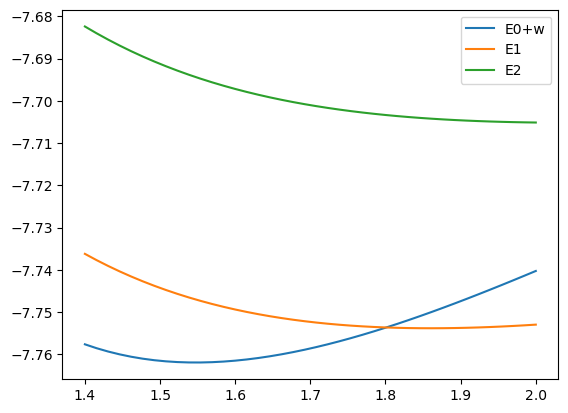

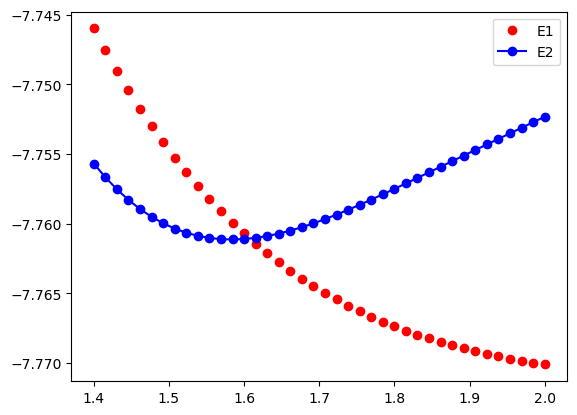

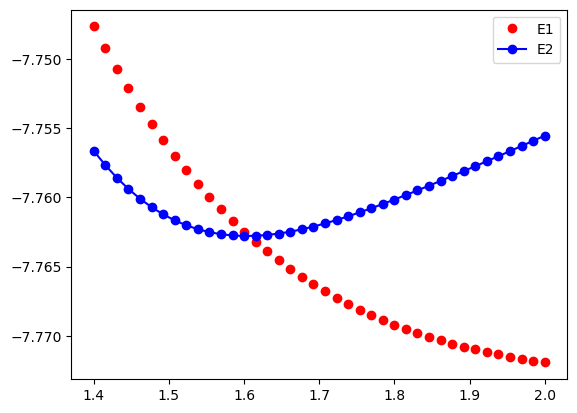

In [9]:
plt.plot(r_array, E_array[:,0]+0.1208, label="E0+w")
plt.plot(r_array, E_array[:,1], label="E1")
plt.plot(r_array, E_array[:,2], label="E2")
plt.legend()
plt.show()


# plt.plot(r_array, sc_np1_E_array[:,0], label="E0")
plt.plot(r_array, sc_np1_E_array[:,1], 'ro', label="E1")
plt.plot(r_array, sc_np1_E_array[:,2], 'bo-', label="E2")
plt.legend()
plt.show()

# plt.plot(r_array, sc_np6_E_array[:,0], label="E0")
plt.plot(r_array, sc_np6_E_array[:,1], 'ro', label="E1")
plt.plot(r_array, sc_np6_E_array[:,2], 'bo-', label="E2")
plt.legend()
plt.show()



\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} + \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\gamma = 1}^N \lambda \cdot \mu_{\alpha, \gamma}(R) \lambda \cdot \mu_{\gamma, \beta} \delta_{nm}
\end{equation}


In [10]:
def build_pf_hamiltonian(n_el, n_ph, E_R, omega, lamvec, mu):
    """
    Given an array of n_el E_R values and an n_ph states with fundamental energy omega
    build the PF Hamiltonian
    
    n_el : int
        the number of electronic states (n_el = 1 means only ground-state)
    
    n_ph : int
        the number of photon occupation states (n_ph = 1 means only the |0> state)
    
    E_R : np.array of floats
        the electronic energies
        
    omega : float
        the energy of the photonic mode
        
    lamvec : np.array of floats
        the lambda vector
        
    mu : (n_el x n_el x 3) np.array of floats 
        mu[i, j, k] is the kth cartesian component of the dipole moment expectation value between 
        state i and state j
    
    """
    H_PF = np.zeros((n_el * n_ph, n_el * n_ph))
    
    # take care of the diagonals first
    # bare electronic and photonic energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a        ####### What are we trying to do here?
            H_PF[na,na] = E_R[a] + n * omega
        
    # diagonal dipole self energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            for g in range(n_el):
                H_PF[na,na] += 0.5 * np.dot(lamvec, mu[a,g,:]) * np.dot(lamvec, mu[g,a,:])
            
    # off-diagonal dipole self energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            for b in range(n_el):
                nb = n * n_el + b
                for g in range(n_el):
                    if a != b:
                        H_PF[na, nb] += 0.5 * np.dot(lamvec, mu[a,g,:]) * np.dot(lamvec, mu[g, b, :])
                
    # off-diagonal bilinear coupling
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            
            for m in range(n_ph):
                for b in range(n_el):
                    mb = m * n_el + b
                    
                    if n == (m-1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na,mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        
                    elif n == (m+1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na, mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1)
                        
    
    return H_PF


def MAE(E, Ep):
    """
    function to return the mean absolute error of the approximate PES stored in Ep relative to 
    the exact PES stored in E
    """
    # get length
    _NR = len(E)
    
    # take element-by-element difference
    _diff = E - Ep
    
    # compute absolute value of differences
    _absdiff = np.abs(_diff)
    
    # return sum divided by _NR
    return np.sum(_absdiff) / _NR
                
            

        
    
    

\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} + \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\gamma = 1}^N \lambda \cdot \mu_{\alpha, \gamma}(R) \lambda \cdot \mu_{\gamma, \beta} \delta_{nm}
\end{equation}


In [11]:
np.set_printoptions(precision=6, linewidth=200, suppress=True)
# omega_cav = 0.12086
# lambda_vector = np.array([0., 0., 0.08])
# N_el = 3
# N_ph = 2
omega_cav = 0.12086
lambda_vector = np.array([0, 0.0, 0.05])
N_el = 2
N_ph = 2

_HPF = build_pf_hamiltonian(N_el, N_ph, E_array[0,:], omega_cav, lambda_vector, Mu_array[0, :, :, :])
print("H")
print(_HPF)


H
[[-7.873822 -0.000088  0.       -0.007412]
 [-0.000088 -7.732121 -0.007412  0.      ]
 [ 0.       -0.007412 -7.752962 -0.000088]
 [-0.007412  0.       -0.000088 -7.611261]]


In [12]:
N_el = 50
N_ph = 20
pcqed_nel50_np20 = np.zeros((N_R, N_el * N_ph ))
for k in range(N_R):           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)   
    pcqed_nel50_np20[k,:] = pf_e

In [13]:
N_el = 2
N_ph = 2
pcqed_nel2_np2 = np.zeros((N_R, N_el * N_ph ))
for k in range(N_R):           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)    
    pcqed_nel2_np2[k,:] = pf_e

In [14]:
N_el = 50
N_ph = 7
pcqed_nel50_np7 = np.zeros((N_R, N_el * N_ph ))
for k in range(N_R):           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)    
    pcqed_nel50_np7[k,:] = pf_e

In [15]:
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

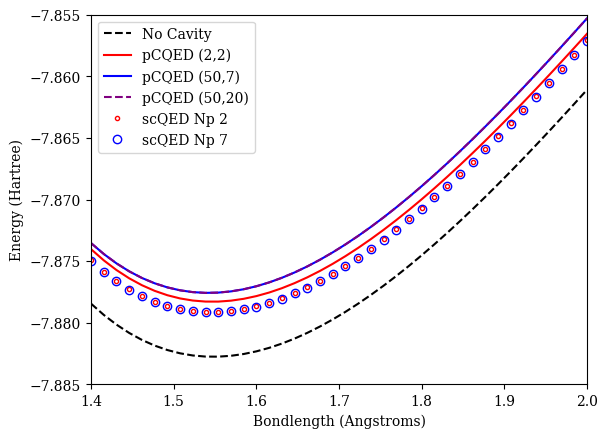

In [30]:
# plt.plot(r_array, Eg_QED_FCI_Np_1)
sc_E_arrat_Np_6 = np.copy(sc_np1_E_array) ####### getting error in this line for not defining sc_E_array
plt.plot(r_array, E_array[:,0], 'black', linestyle="dashed", label="No Cavity")
plt.plot(r_array, pcqed_nel2_np2[:,0], 'red', label="pCQED (2,2)")
plt.plot(r_array, pcqed_nel50_np7[:,0], 'blue', label="pCQED (50,7)")
plt.plot(r_array, pcqed_nel50_np20[:,0], 'purple', linestyle="dashed", label="pCQED (50,20)")
plt.plot(r_array, sc_np1_E_array[:,0], 'ro', ms = 3, mfc = 'none', label="scQED Np 2")
plt.plot(r_array, sc_np6_E_array[:,0], 'bo', ms = 6, mfc = 'none', label="scQED Np 7") # edgecolors='red')
plt.xlim(1.4, 2.0)
plt.ylim(-7.885, -7.855)
plt.ylabel("Energy (Hartree)")
plt.xlabel("Bondlength (Angstroms)")
plt.legend()
plt.savefig("sto3g_lih_ground_state_lambda_05.png")
plt.show()

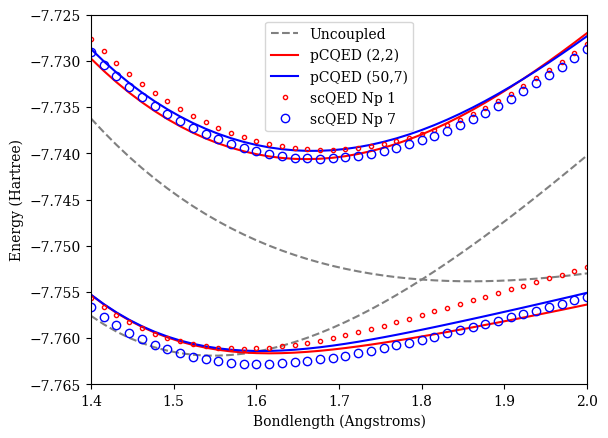

In [31]:
rcParams['font.size'] = 10
plt.plot(r_array, E_array[:,0]+0.12086, 'grey', linestyle="dashed", label="Uncoupled")
plt.plot(r_array, E_array[:,1], 'grey', linestyle="dashed")#, label="Ee Uncoupled")
plt.plot(r_array, pcqed_nel2_np2[:,1], 'red', label="pCQED (2,2)")
plt.plot(r_array, pcqed_nel2_np2[:,2], 'red')# label="pCQED (2,2)")
plt.plot(r_array, pcqed_nel50_np7[:,1], 'blue',  label="pCQED (50,7)")
plt.plot(r_array, pcqed_nel50_np7[:,2], 'blue')#,  label="pCQED (50,7)")
plt.plot(r_array, sc_np1_E_array[:,2], 'ro', ms = 3, mfc = 'none', label="scQED Np 1")
plt.plot(r_array, sc_np1_E_array[:,3], 'ro', ms = 3, mfc = 'none')#, label="scQED Np 1")
plt.plot(r_array, sc_np6_E_array[:,2], 'bo', ms = 6, mfc = 'none', label="scQED Np 7")
plt.plot(r_array, sc_np6_E_array[:,3], 'bo', ms = 6, mfc = 'none')#, label="scQED Np 7")
plt.xlim(1.4, 2.0)
plt.ylim(-7.765, -7.725)
plt.ylabel("Energy (Hartree)")
plt.xlabel("Bondlength (Angstroms)")
plt.legend()
plt.savefig("sto3g_lih_lp_up_lambda_05.png")
plt.show()

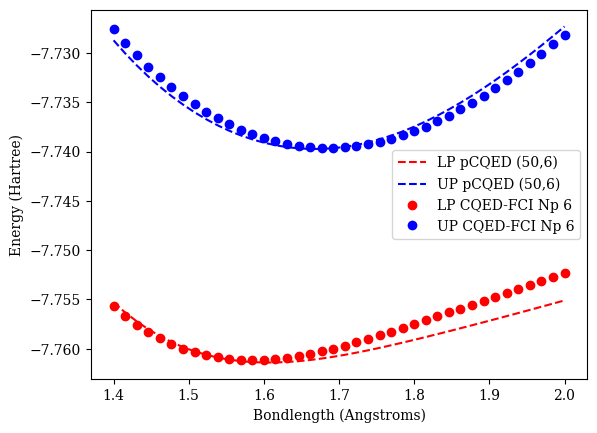

In [32]:
# plt.plot(r_array, pcqed_nel50_np6[:,1], 'r--', label="LP pCQED (50,6)")
# plt.plot(r_array, pcqed_nel50_np6[:,2], 'b--', label="UP pCQED (50,6)")
# plt.plot(r_array, sc_E_arrat_Np_6[:,2], 'ro', label="LP CQED-FCI Np 6")
# plt.plot(r_array, sc_E_arrat_Np_6[:,3], 'bo', label="UP CQED-FCI Np 6")
# plt.ylabel("Energy (Hartree)")
# plt.xlabel("Bondlength (Angstroms)")
# plt.legend()
# plt.show()

plt.plot(r_array, pcqed_nel50_np7[:,1], 'r--', label="LP pCQED (50,6)")
plt.plot(r_array, pcqed_nel50_np7[:,2], 'b--', label="UP pCQED (50,6)")
plt.plot(r_array, sc_E_arrat_Np_6[:,2], 'ro', label="LP CQED-FCI Np 6")
plt.plot(r_array, sc_E_arrat_Np_6[:,3], 'bo', label="UP CQED-FCI Np 6")
plt.ylabel("Energy (Hartree)")
plt.xlabel("Bondlength (Angstroms)")
plt.legend()
plt.show()

In [34]:
# for i in range(N_R):
#     print(F'{r_array[i]}, {pf_array[i,0]}, {pf_array[i,1]}, {pf_array[i,2]}, {pf_array[i,3]}, {pf_array[i,3]} ')
      